# Make efficiency map plots for trained fitters

In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import util as ut

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

from pprint import pprint

import itertools

# import xgboost

Welcome to ROOTaaS 6.06/08


In [2]:
#note that the loading option is True by default
ut.defaultParameters(dataDir='./data', inputName="effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out", inputDir='./classifiers')
ut.setParams()
effFitter = ut.loadOrMake()

entered config files named my_train_config
None
Load object with the name effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out and the following paramters 
./classifiers
./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.pkl.gz
loading pickle ./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.pkl.gz
loading data ./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.root
Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'proc', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPtCat_prob_0',
       u'recoPtCat_prob_1', u'recoPtCat_prob_2', u'recoPtCat_prob_3',
       u'rec

## projection on the following 2 variables

In [3]:
x_var = 'genJet2p5Rapidity0'
y_var = 'genJet2p5Pt0'

In [4]:
def GetBins (x_pt, y_pt, x_name, y_name) :
    N_PtBins = 8
    N_RapidityBins = 8
    if (x_pt and y_pt) :
        return { x_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False), 
                       y_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False)
            }   
    else :
        if x_pt :
            return { x_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False), 
                           y_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False)
                          }
        if y_pt :
            return { x_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False), 
                           y_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False)
                          }
    return { x_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False), 
             y_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False)
                        }

### define bins in genJet2p5Rapidity0 and genJet2p5Pt0

In [5]:
defineBins = GetBins(x_pt=False,y_pt=True,x_name=x_var,y_name=y_var)

In [6]:
ut.runDefineBins(effFitter,defineBins)

### Extract data frame and start getting the probas in a binned way

In [7]:
df = effFitter.df
first_train_evt = int(round(df.index.size*(1.-effFitter.split_frac)))

#take the test sample 
df_test = df[:first_train_evt]

In [8]:
def weighted_average(df_name, column_name, weight_name=None):
    """
    This function computes the weighted average of the quantity column_name
    stared in the pandas dataframe df_name. In case no weights are given
    or if they sum up to zero, the mean is returned instead.
    :params 
            df_name :
        column_name :
        weight_name :
    :retruns
                    :
    """
    d = df_name[column_name]
    w = df_name[weight_name]
    #print(len(w))
    if (weight_name == None) :
        return float(d.mean())
    else :
        try:
            return (d * w).sum() / float(w.sum())
        except ZeroDivisionError:
            return float(d.mean())

In [9]:
def weight_freq (df_name, column_name, equal_to, weight_name) :
    df = df_name#[df_name[column_name]==equal_to]
    
    w_all = df[weight_name].sum()
    w_PartPhaseSpace = df[df[column_name] == equal_to][weight_name].sum()
    #print(w_all)
    #print(w_PartPhaseSpace)
    return w_PartPhaseSpace / w_all

In [10]:
def plot_imshow(groupby_objects, 
                          titles=[],
                        x_lab = None,
                        y_lab = None,
                          cmap=plt.cm.Blues,
                   effTag=False, effPlot=False):
   


    if effTag :
        plot_imshow(groupby_objects, titles=['predicted (clf) reco eff', 'true (data) reco eff'],
                        x_lab = x_lab, y_lab = y_lab, cmap=plt.cm.Reds, effTag=False, effPlot=True)
    else :
        
        fig = plt.figure(figsize=(8,8))

        max_col = 1.
        min_col = 0.


        for k, r in enumerate(groupby_objects) :

            x,y = r.index.levels
 
            cm = r.values.reshape(len(x),len(y))
            if effPlot :
                cm = 1. - cm

            if (cm.max() < max_col) :
                max_col = cm.max()
            if (cm.min() > min_col) :
                min_col = cm.min()

            plt.subplot('12'+str(k+1))
            
            #check this
            cm = cm.T
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap,origin='lower')
            plt.title(titles[k])

            xtick_marks = np.arange(len(x))
            ytick_marks = np.arange(len(y))

            plt.xticks(xtick_marks, xtick_marks)
            plt.yticks(ytick_marks, ytick_marks)


            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, np.round(cm[i, j],2), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


            plt.xlabel(x_lab)
            if k == 0 :
                plt.ylabel(y_lab)
            plt.tight_layout()

        plt.clim(min_col,max_col)
        fig.subplots_adjust(top=0.98)   
        cbar_ax = fig.add_axes([0.15, 0.97, 0.7, 0.02])
        plt.colorbar(cax=cbar_ax,orientation='horizontal')#,norm=plt.colors.Normalize(vmin=min_col,vmax=max_col))
    
    
        
    

perform efficiency (1- reco-proba) plot


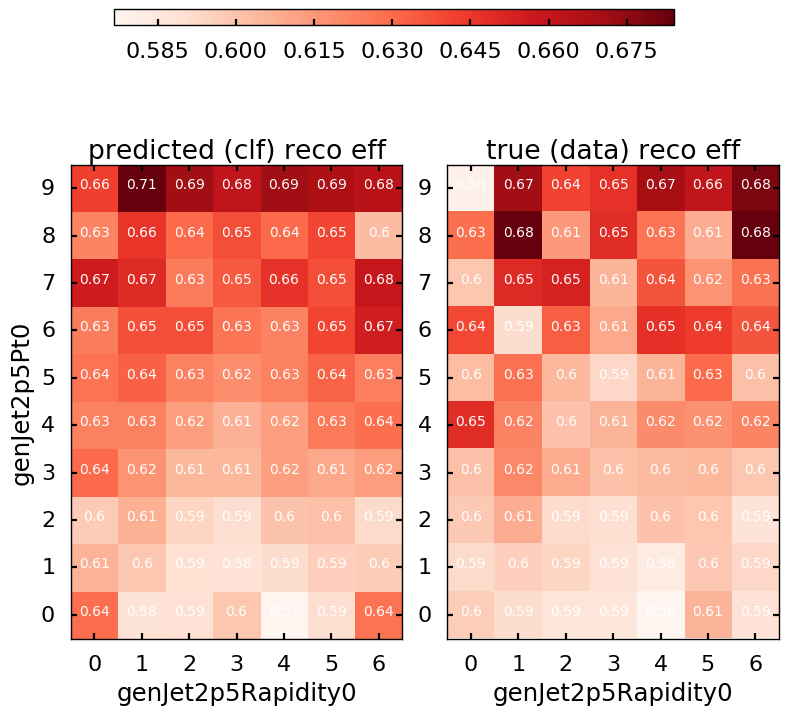

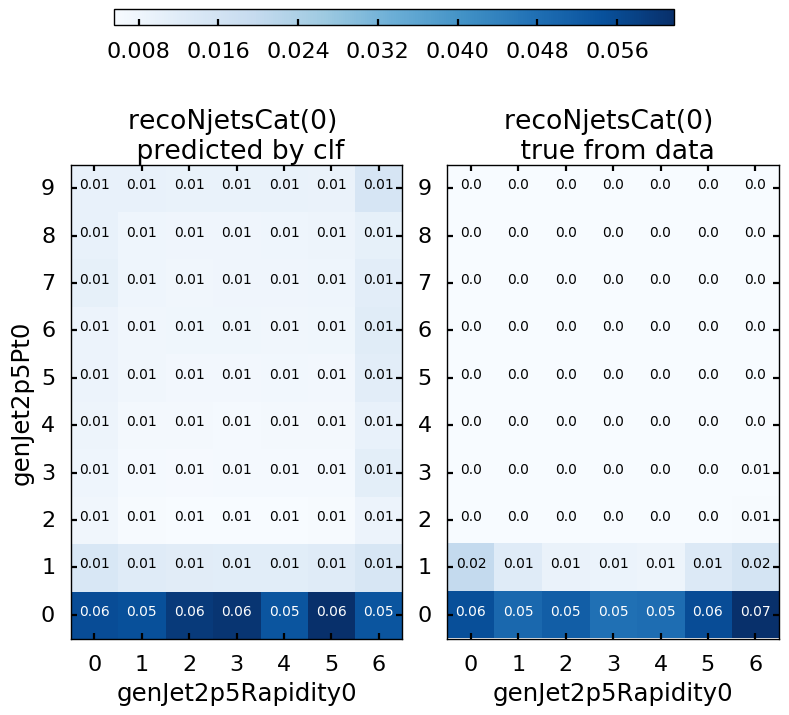

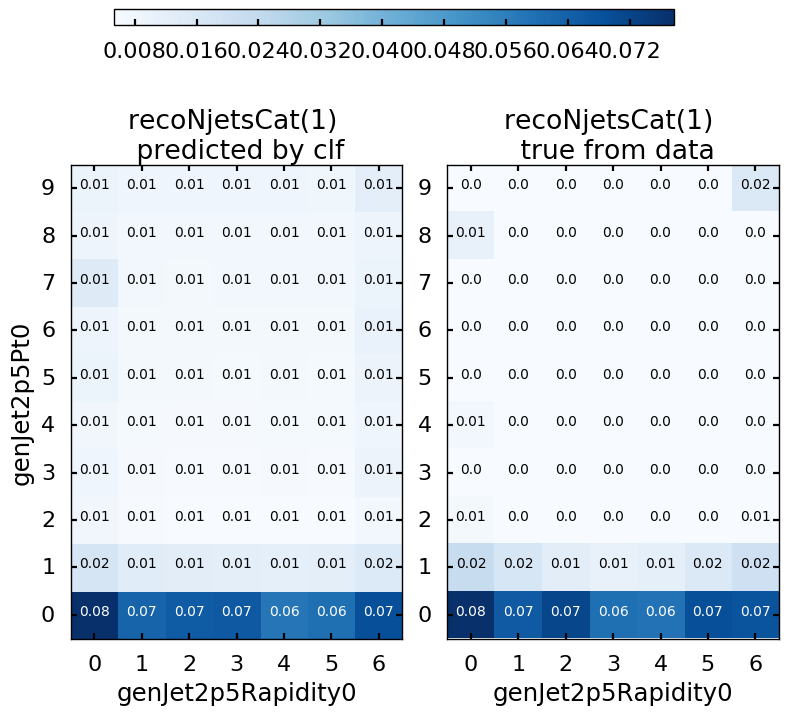

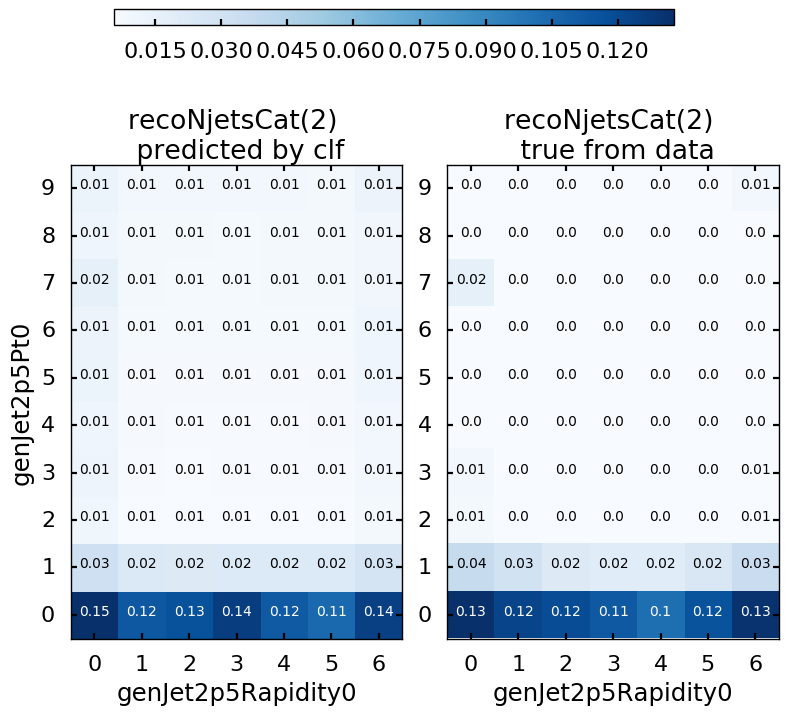

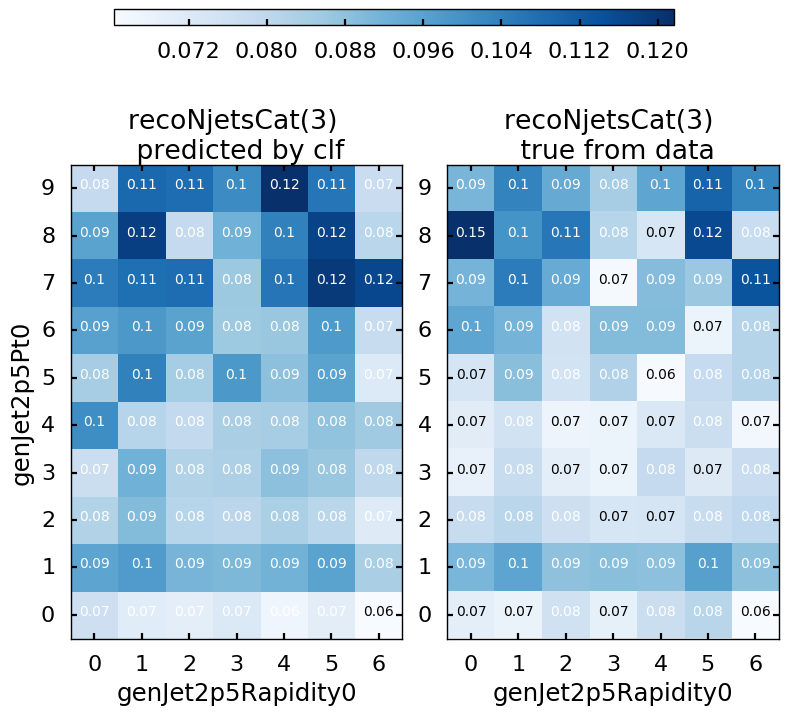

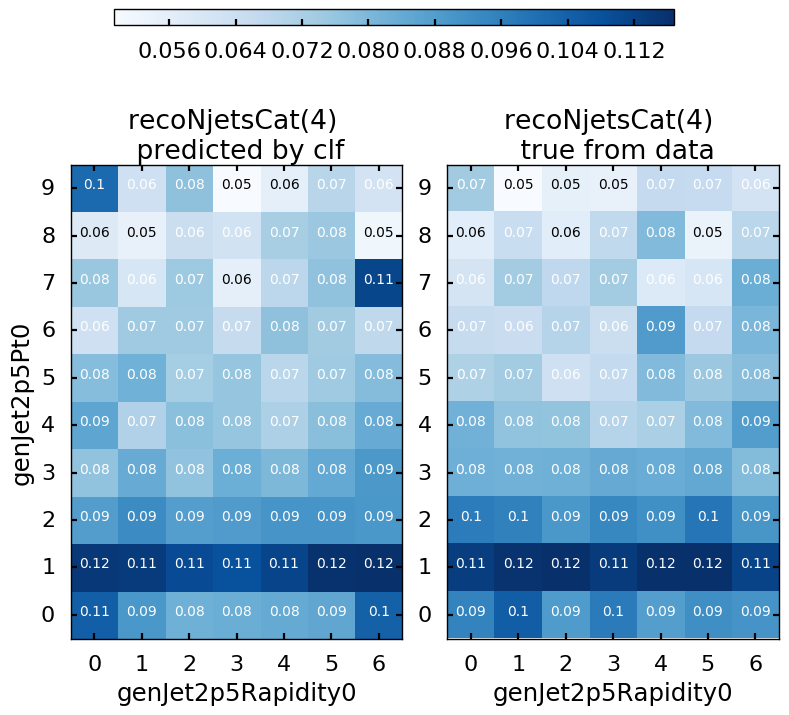

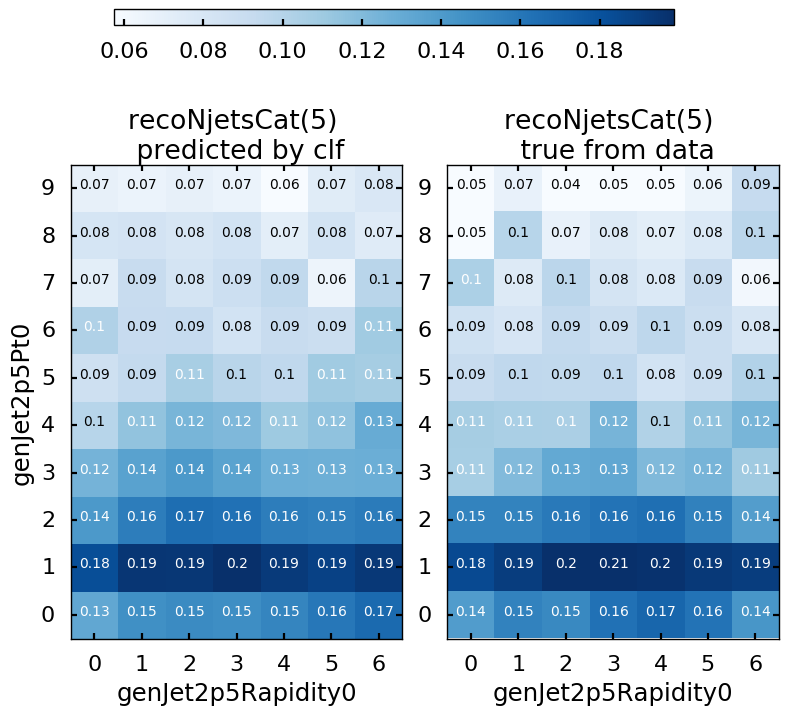

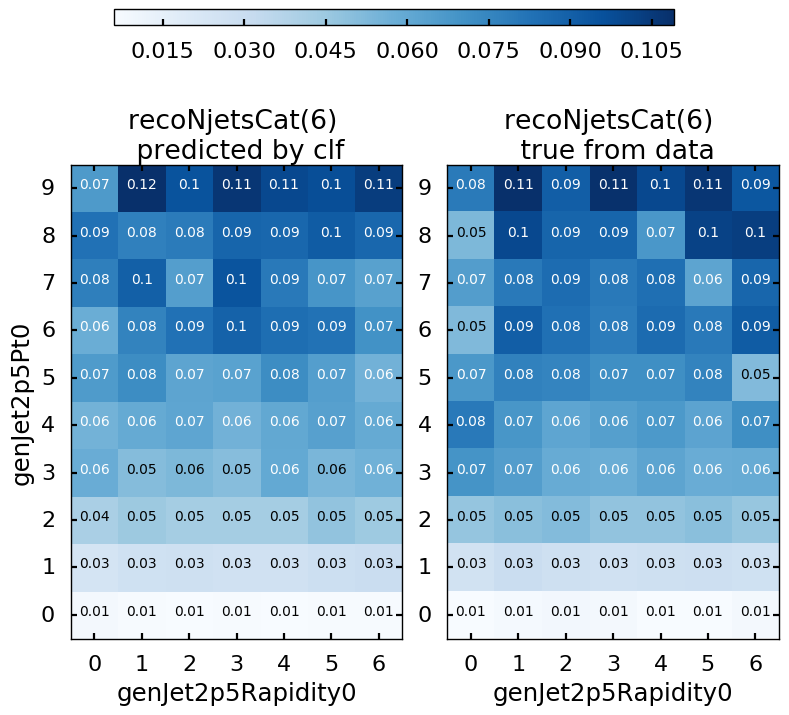

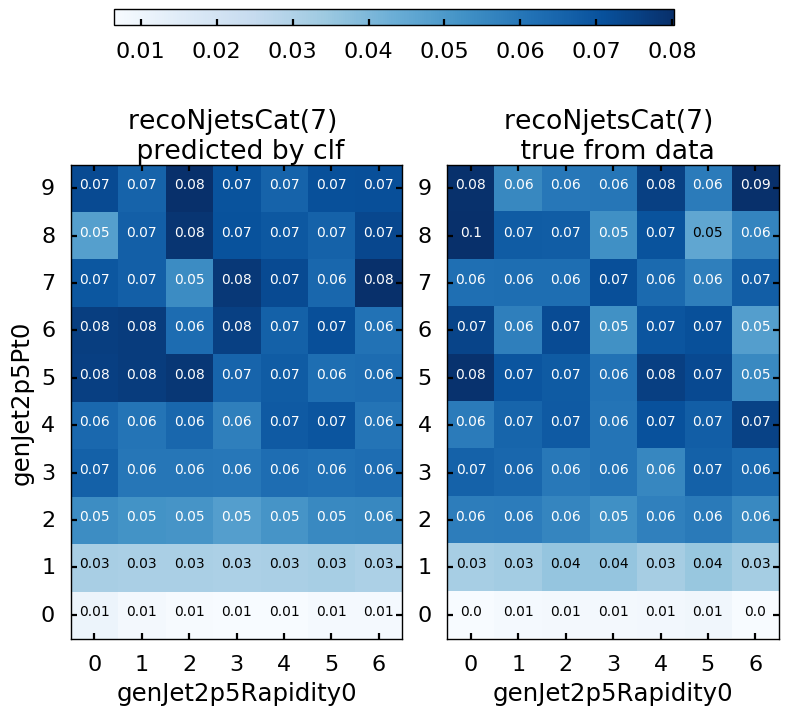

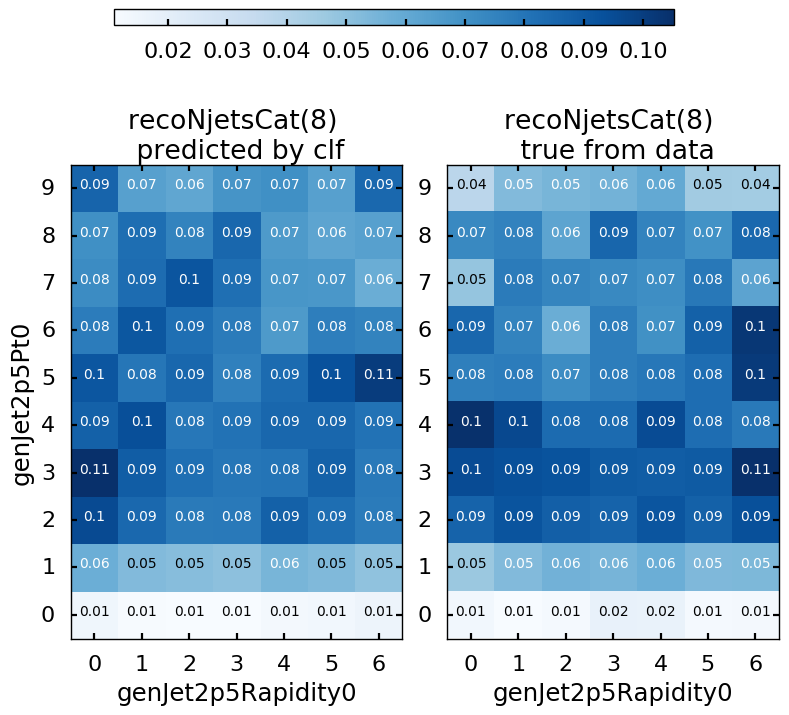

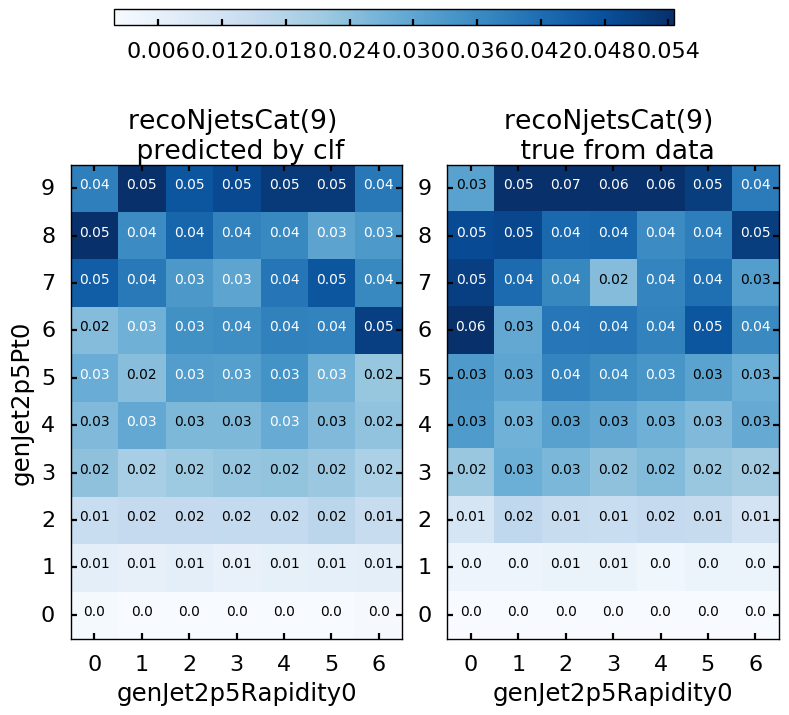

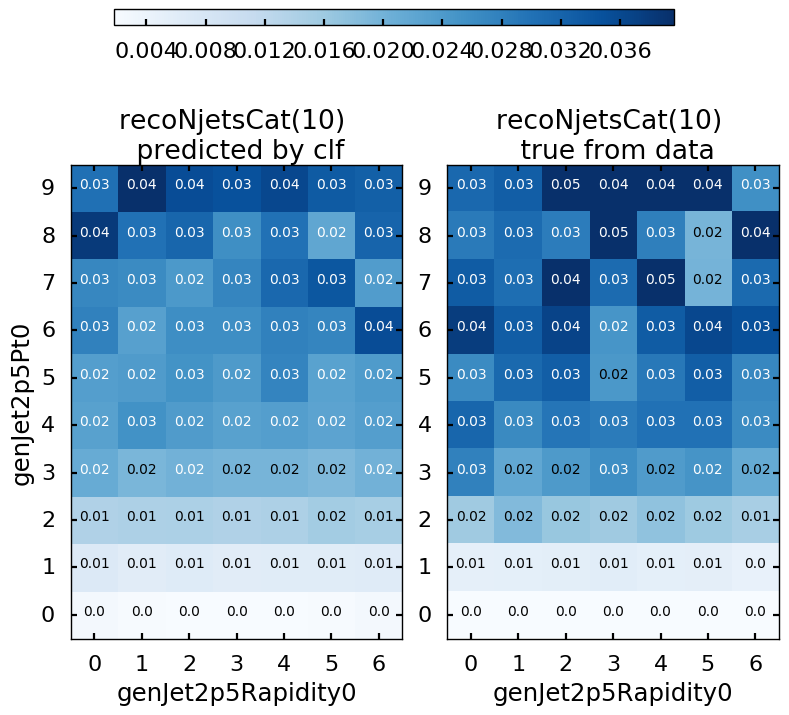

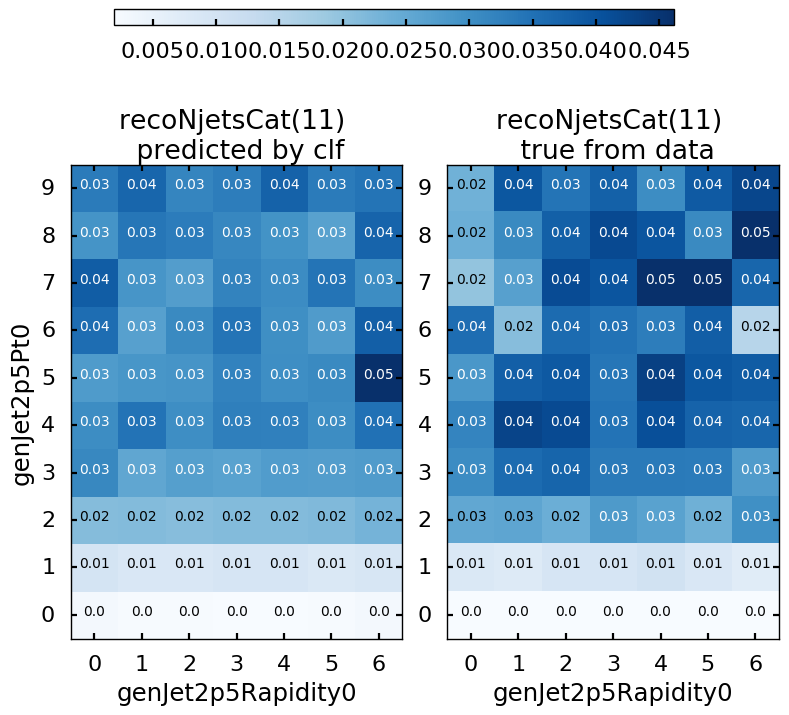

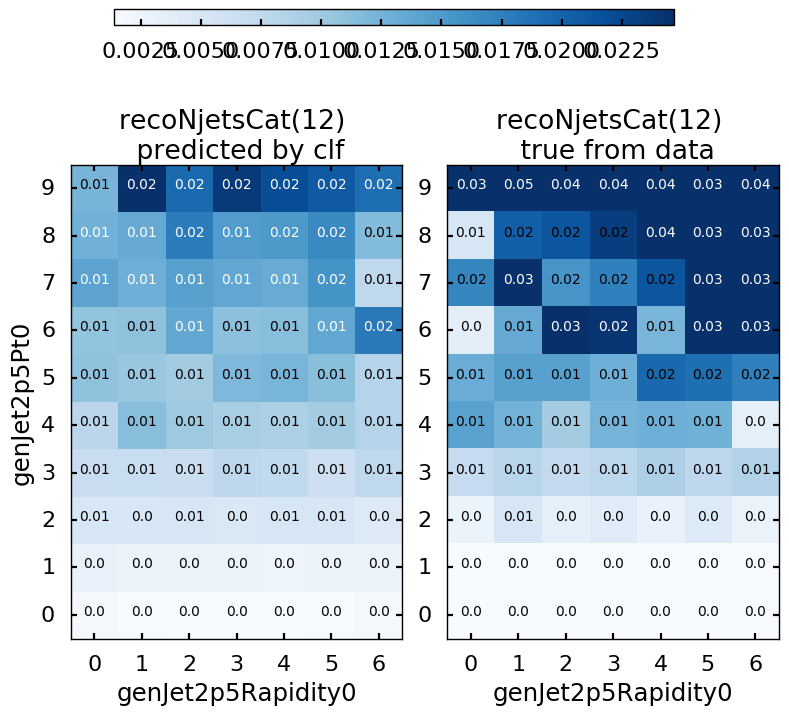

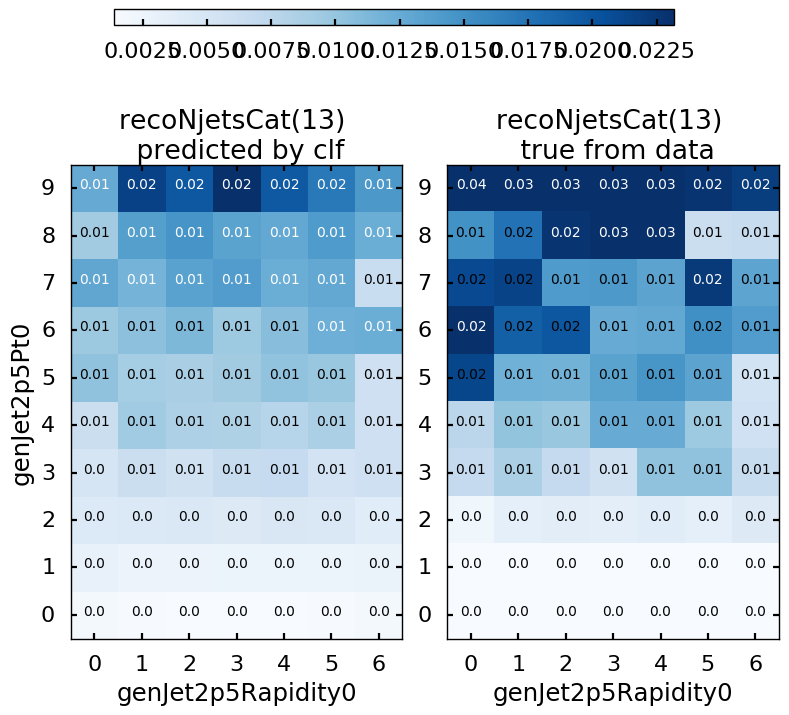

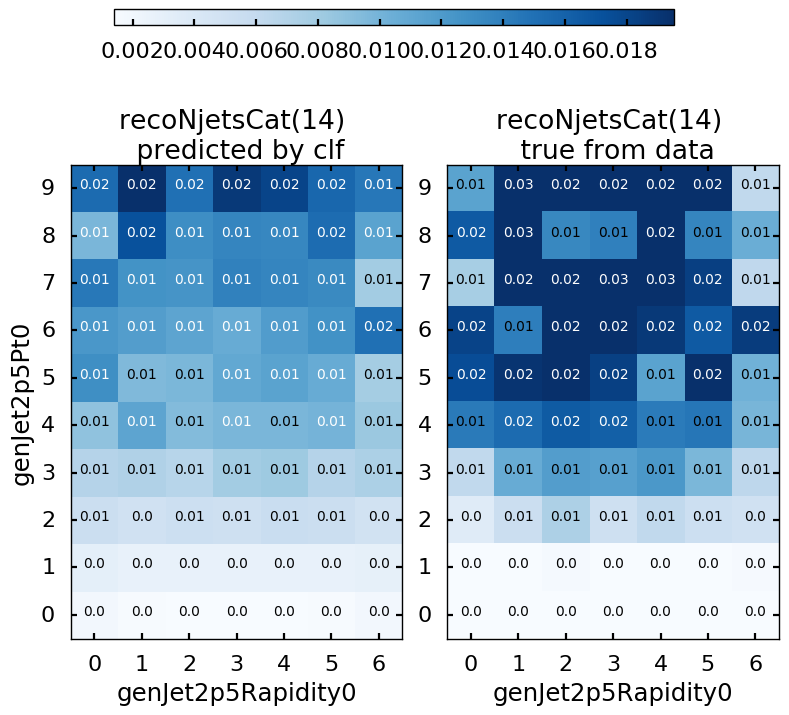

In [11]:
N_recoNjets2p5Cats = 16

for i in np.arange(N_recoNjets2p5Cats) :
    column_proba_name = 'recoNjets2p5Cat_prob_'+str(i)
    
    gb_freq  = df.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"recoNjets2p5Cat",(i-1),'absweight')
    gb_proba = df_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, column_proba_name,'absweight')
    
    
    title1 ='recoNjetsCat('+str(i-1)+') \n predicted by clf'
    title2 ='recoNjetsCat('+str(i-1)+') \n true from data'
   
    if (i==0) :
        print('perform efficiency (1- reco-proba) plot')
        plot_imshow([gb_proba,gb_freq],x_lab=x_var,y_lab=y_var,titles=['predicted (clf) reco eff',
                                                                    'true data reco eff'],effTag=True)
    else :
        plot_imshow([gb_proba,gb_freq],x_lab=x_var,y_lab=y_var,titles=[title1,title2])
 
    

In [12]:
from matplotlib import ticker

#### Perform plots with realtive ratio of true and predicted probas:  $ \frac{\text{true} - \text{pred}}{\text{true}} $

In [13]:
def plotRelDiff_imshow(groupby_objects, 
                        x_lab = None,
                        y_lab = None,
                          cmap=plt.cm.Blues):
   
        
    fig = plt.figure(figsize=(7,7))

    r_pred, r_true = groupby_objects

    x_pred,y_pred = r_pred.index.levels
    x_true,y_true = r_true.index.levels

    cm_pred = r_pred.values.reshape(len(x_pred),len(y_pred))
    cm_true = r_true.values.reshape(len(x_true),len(y_true))

    plt.subplot(111)
    cm = np.divide((cm_true-cm_pred),cm_true, out=np.zeros_like(cm_true-cm_pred), where=cm_true!=0)
    
    cm = cm.T
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap,origin='lower')
    plt.title('({true} - {pred}) / {true} \n')
    
    
    
    xtick_marks = np.arange(len(x_true))
    ytick_marks = np.arange(len(y_true))


    plt.xticks(xtick_marks, xtick_marks)
    plt.yticks(ytick_marks, ytick_marks)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.tight_layout()

    fig.subplots_adjust(top=0.78)   
    cbar_ax = fig.add_axes([0.15, 0.97, 0.7, 0.02])
    cb = plt.colorbar(cax=cbar_ax,orientation='horizontal')#,norm=plt.colors.Normalize(vmin=min_col,vmax=max_col))

    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
       
    

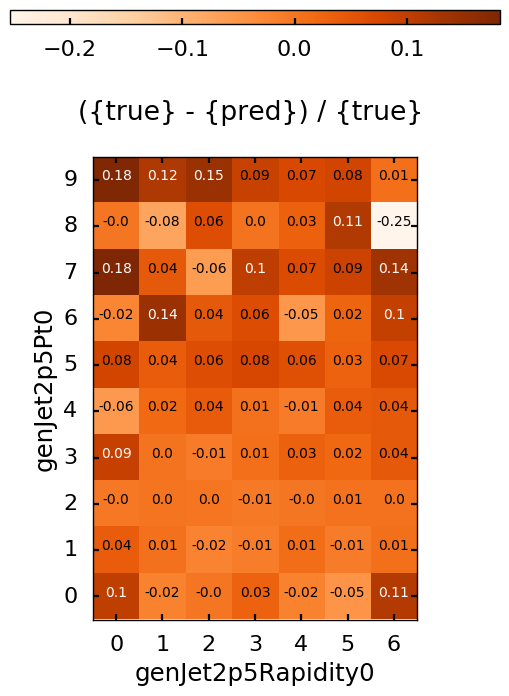

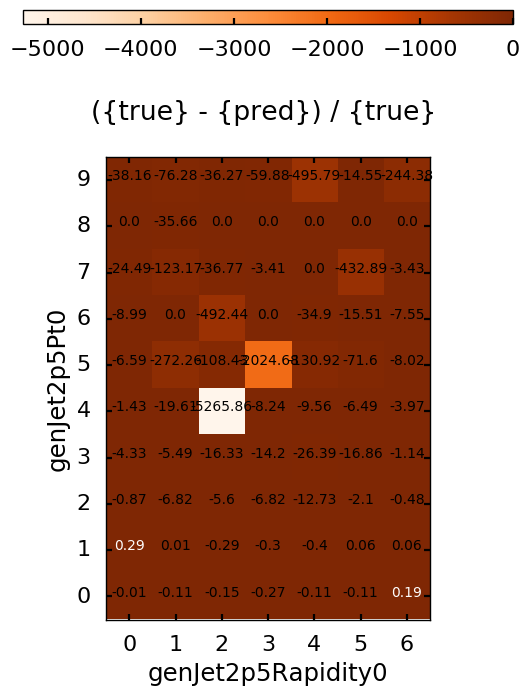

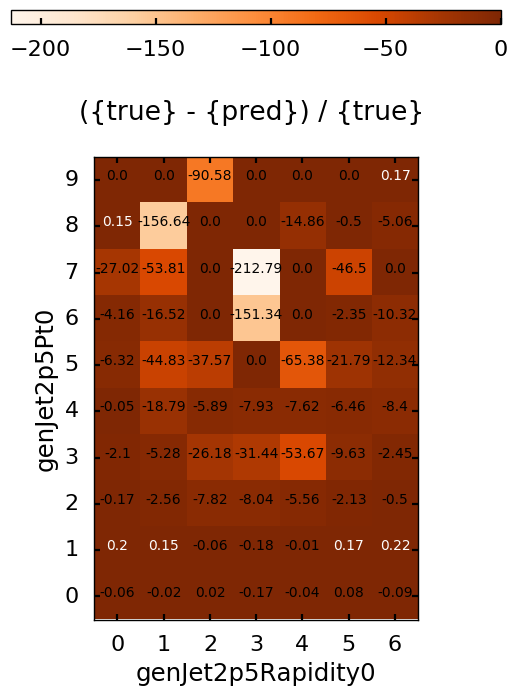

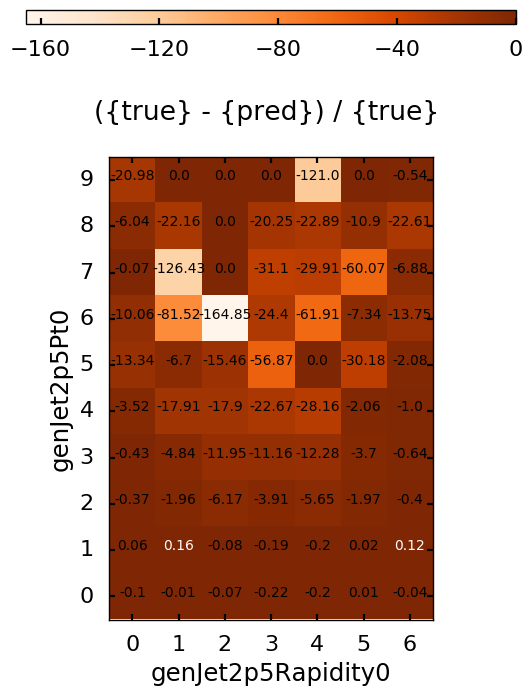

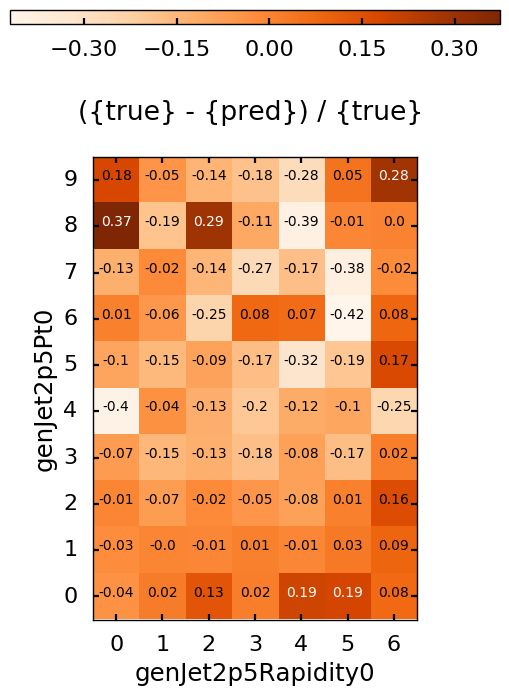

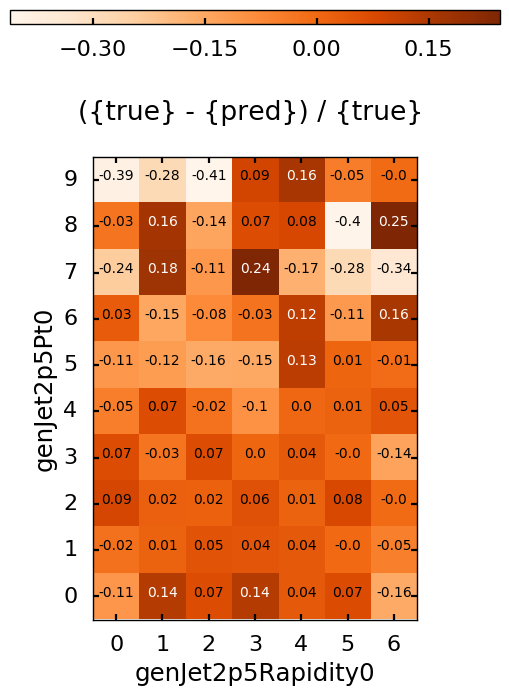

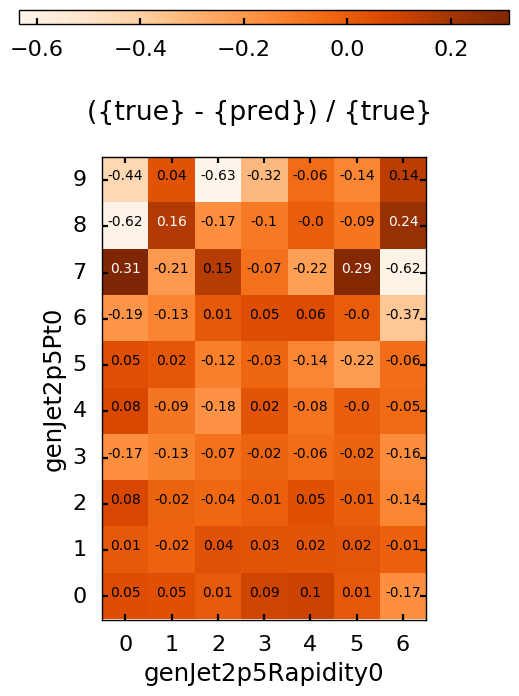

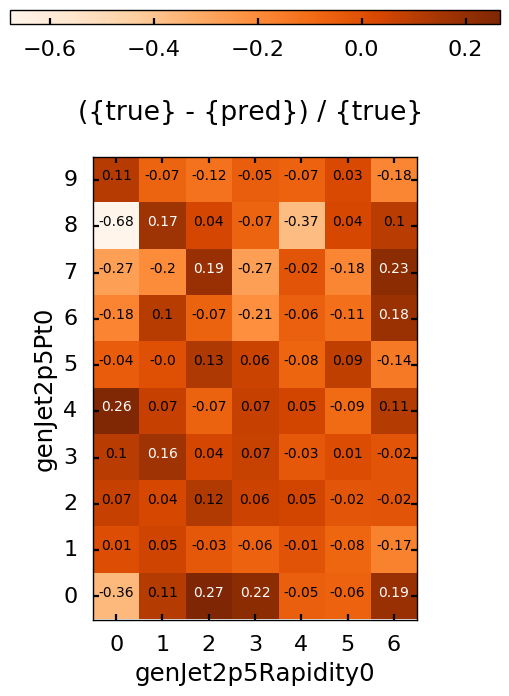

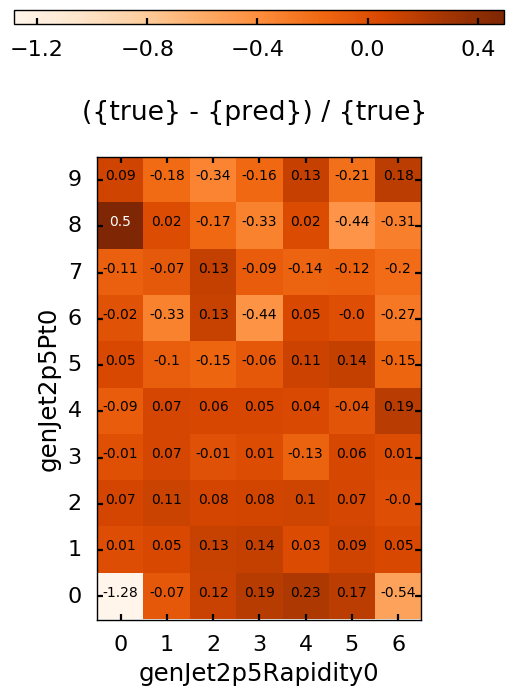

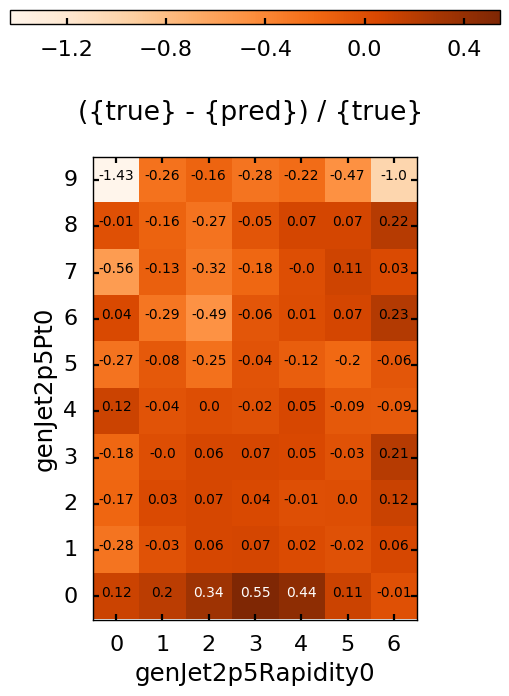

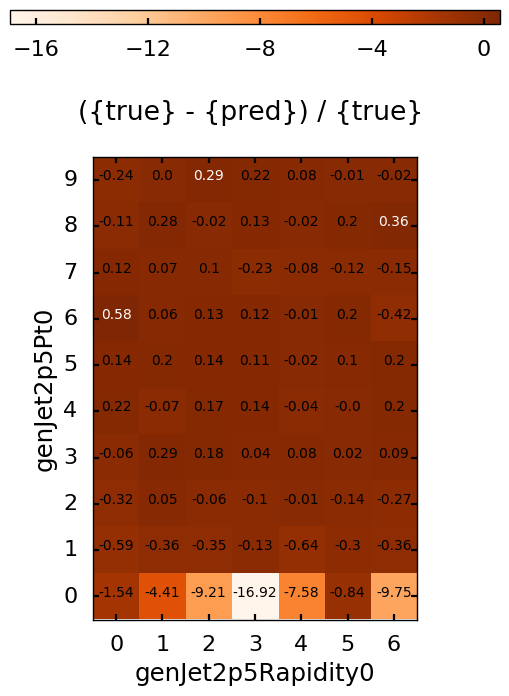

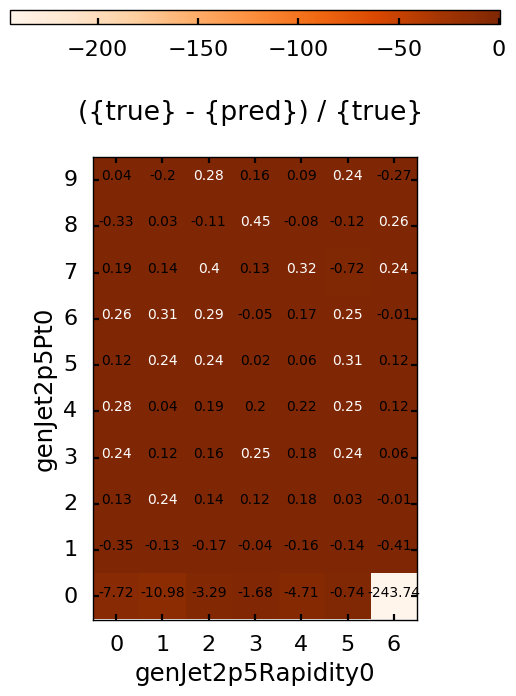

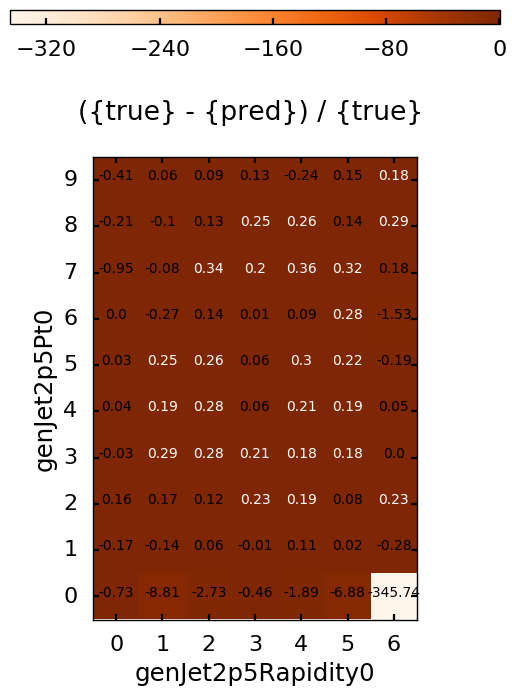

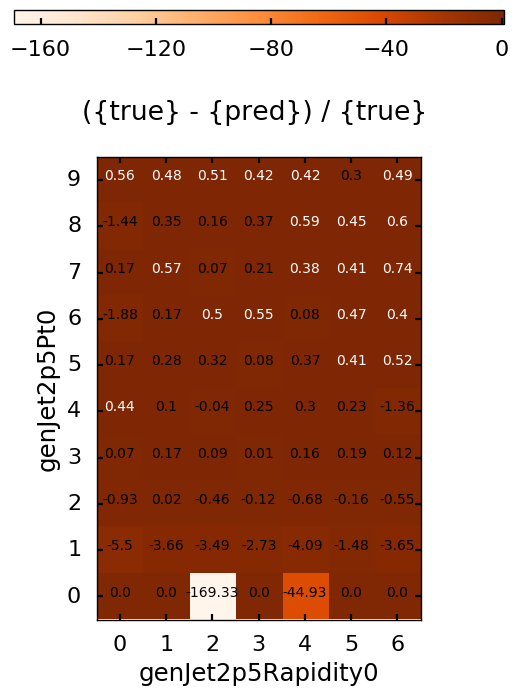

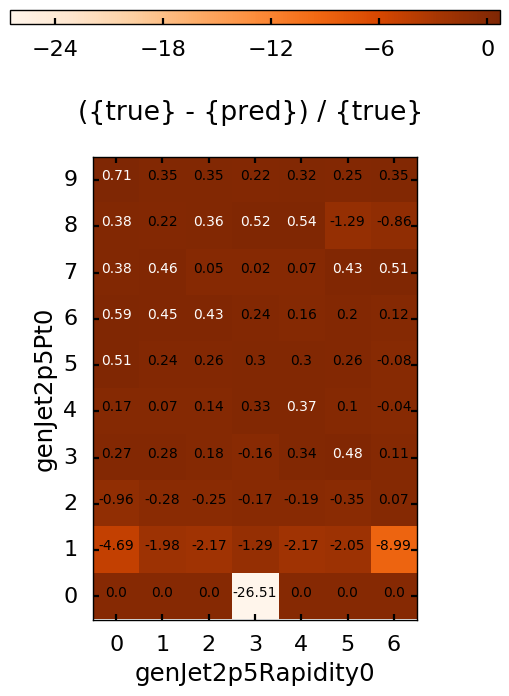

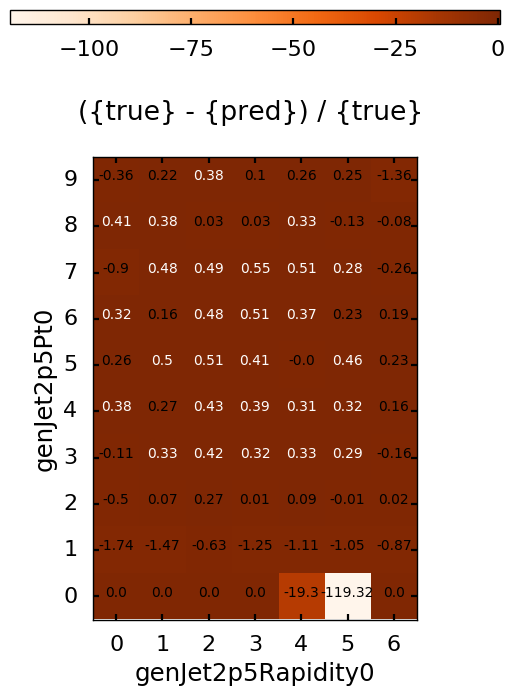

In [14]:
N_recoNjets2p5Cats = 16

for i in np.arange(N_recoNjets2p5Cats) :
    column_proba_name = 'recoNjets2p5Cat_prob_'+str(i)
    
    gb_freq  = df.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"recoNjets2p5Cat",(i-1),'absweight')
    gb_proba = df_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, column_proba_name,'absweight')
    
    plotRelDiff_imshow([gb_proba,gb_freq],x_lab=x_var,y_lab=y_var,cmap=plt.cm.Oranges)